In [1]:
import pandas as pd
from pyspark.ml.classification import LogisticRegression, NaiveBayes, RandomForestClassifier, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.feature import StringIndexer,VectorAssembler, OneHotEncoder
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import lit
from pyspark.sql import SparkSession
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [2]:
spark = SparkSession.builder.getOrCreate() #connection to pyspark ie sqlContext

In [3]:
# 1.Load data using PySpark

data=spark.read.csv('data/censusdata.csv',header=True)
#Let's Check the first 5 entries
data.show(n=5)

+---+----------------+------+------------+-------------+------------------+---------------+--------------+-----+------+------------+------------+--------------+--------------+------+
|age|       workclass|fnlwgt|   education|education_num|    marital_status|     occupation|  relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+----------------+------+------------+-------------+------------------+---------------+--------------+-----+------+------------+------------+--------------+--------------+------+
| 22|         Private|148187|        11th|            7|     Never-married|  Other-service|Other-relative|White|  Male|           0|           0|            40| United-States| <=50K|
| 77|Self-emp-not-inc|138714|Some-college|           10|Married-civ-spouse|          Sales|       Husband|White|  Male|           0|           0|            40| United-States| <=50K|
| 47|               ?|224108|     HS-grad|            9|           Widowed|          

In [4]:
# 2. Perform Exploratory Data Analysis (EDA) and Data Cleaning 

In [5]:
# a. Find the shape and schema of the dataset
data.schema

StructType(List(StructField(age,StringType,true),StructField(workclass,StringType,true),StructField(fnlwgt,StringType,true),StructField(education,StringType,true),StructField(education_num,StringType,true),StructField(marital_status,StringType,true),StructField(occupation,StringType,true),StructField(relationship,StringType,true),StructField(race,StringType,true),StructField(sex,StringType,true),StructField(capital_gain,StringType,true),StructField(capital_loss,StringType,true),StructField(hours_per_week,StringType,true),StructField(native_country,StringType,true),StructField(income,StringType,true)))

In [6]:
data.toPandas().shape

(92561, 15)

In [7]:
# b. Obtain insights (statistics) of different columns
data_desc=data.describe()
data_desc.toPandas()

,summary,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,count,92561,92561,92561,92561,92561,92561,92561,92561,92561,92561,92561,92561,92561,92561,92561
1,mean,38.518069165199165,None,189542.36106999707,None,10.075236870820325,None,None,None,None,None,1046.2974362852606,87.93313598599842,40.433087369410444,None,None
2,stddev,13.622754122275927,None,105813.13085282373,None,2.5732149715644352,None,None,None,None,None,7220.801020868538,404.3217769832552,12.324730527252393,None,None
3,min,17,?,100009,10th,1,Divorced,?,Husband,Amer-Indian-Eskimo,Female,0,0,1,?,<=50K
4,max,90,Without-pay,99987,Some-college,9,Widowed,Transport-moving,Wife,White,Male,99999,974,99,Yugoslavia,>50K


In [8]:
# c. Obtain the Unique values of Categorical Columns
data.dtypes

[('age', 'string'),
 ('workclass', 'string'),
 ('fnlwgt', 'string'),
 ('education', 'string'),
 ('education_num', 'string'),
 ('marital_status', 'string'),
 ('occupation', 'string'),
 ('relationship', 'string'),
 ('race', 'string'),
 ('sex', 'string'),
 ('capital_gain', 'string'),
 ('capital_loss', 'string'),
 ('hours_per_week', 'string'),
 ('native_country', 'string'),
 ('income', 'string')]

In [9]:
cat_cols=['workclass','education','education_num','marital_status','occupation','relationship','race','sex','native_country','income']
for col in cat_cols:
    print(str(col )+"\t Unique values: "+str(data.select(col).distinct().rdd.map(lambda r: r[0]).collect()))

workclass	 Unique values: [u'Self-emp-not-inc', u'Local-gov', u'State-gov', u'Private', u'Without-pay', u'Federal-gov', u'Never-worked', u'?', u'Self-emp-inc']
education	 Unique values: [u'Masters', u'10th', u'5th-6th', u'Assoc-acdm', u'Assoc-voc', u'7th-8th', u'9th', u'HS-grad', u'Bachelors', u'11th', u'1st-4th', u'Preschool', u'12th', u'Doctorate', u'Some-college', u'Prof-school']
education_num	 Unique values: [u'7', u'15', u'11', u'3', u'8', u'16', u'5', u'6', u'9', u'1', u'10', u'4', u'12', u'13', u'14', u'2']
marital_status	 Unique values: [u'Separated', u'Never-married', u'Married-spouse-absent', u'Divorced', u'Widowed', u'Married-AF-spouse', u'Married-civ-spouse']
occupation	 Unique values: [u'Sales', u'Exec-managerial', u'Prof-specialty', u'Handlers-cleaners', u'Farming-fishing', u'Craft-repair', u'Transport-moving', u'Priv-house-serv', u'Protective-serv', u'Other-service', u'Tech-support', u'Machine-op-inspct', u'Armed-Forces', u'?', u'Adm-clerical']
relationship	 Unique value

In [10]:
# d. Check if any unwanted values are present in the data such as Null, ? or NaN
# Number of null values
for i in data.columns:
    print(i,data.where(data[i].isNull()).count()) # this is df.isnull().sum()

('age', 0)
('workclass', 0)
('fnlwgt', 0)
('education', 0)
('education_num', 0)
('marital_status', 0)
('occupation', 0)
('relationship', 0)
('race', 0)
('sex', 0)
('capital_gain', 0)
('capital_loss', 0)
('hours_per_week', 0)
('native_country', 0)
('income', 0)


In [11]:
for col in data.columns:
    print(col, data.filter(data[col]=='NaN').count()) # same as above

('age', 0)
('workclass', 0)
('fnlwgt', 0)
('education', 0)
('education_num', 0)
('marital_status', 0)
('occupation', 0)
('relationship', 0)
('race', 0)
('sex', 0)
('capital_gain', 0)
('capital_loss', 0)
('hours_per_week', 0)
('native_country', 0)
('income', 0)


In [12]:
# e. Remove unwanted values if present in any of the columns (numerical as well as categorical columns)

# No unwanted values found

In [13]:
df=pd.DataFrame(data.toPandas())
df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,22,Private,148187,11th,7,Never-married,Other-service,Other-relative,White,Male,0,0,40,United-States,<=50K
1,77,Self-emp-not-inc,138714,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States,<=50K
2,47,?,224108,HS-grad,9,Widowed,?,Unmarried,White,Female,0,0,40,United-States,<=50K
3,23,Private,314894,HS-grad,9,Never-married,Exec-managerial,Own-child,White,Female,0,0,45,United-States,<=50K
4,46,Private,166181,Some-college,10,Never-married,Adm-clerical,Own-child,Black,Female,0,0,36,United-States,<=50K


In [14]:
# f. Obtain the relationship between different columns using covariance which shows the degree of interdependence of the two columns

df.cov

<bound method DataFrame.cov of       age         workclass  fnlwgt     education education_num  \
0      22           Private  148187          11th             7   
1      77  Self-emp-not-inc  138714  Some-college            10   
2      47                 ?  224108       HS-grad             9   
3      23           Private  314894       HS-grad             9   
4      46           Private  166181  Some-college            10   
5      29         State-gov  204516       Masters            14   
6      35           Private  407913       HS-grad             9   
7      28           Private   96219     Bachelors            13   
8      58      Self-emp-inc   78104       HS-grad             9   
9      19                 ?  252292       HS-grad             9   
10     32           Private  207668       HS-grad             9   
11     67  Self-emp-not-inc  191380   Prof-school            15   
12     47         State-gov   80914       Masters            14   
13     36         Local-gov  24

In [15]:
# g. Obtain distinct values and their counts in categorical columns

data['workclass','education','education_num','marital_status','occupation','relationship','race','sex','native_country','income'].toPandas().nunique()

workclass          9
education         16
education_num     16
marital_status     7
occupation        15
relationship       6
race               5
sex                2
native_country    42
income             2
dtype: int64

In [16]:
data.columns

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education_num',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'native_country',
 'income']

In [17]:
# h. Create a crosstab on two different columns (example, age & workclass)
'''for i in range(0,len(data.columns)):
    for j in range(1,len(data.columns)):
        pd.crosstab(df[data.columns[i]],df[data.columns[j]])'''

        
pd.crosstab(df['age'],df['workclass'])


workclass,?,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay
age,,,,,,,,,
17,163,2,36,2,888,14,22,7,0
18,270,11,24,11,1204,23,41,28,0
19,311,16,23,0,1573,8,44,53,5
20,321,26,36,3,1627,7,33,63,0
21,251,4,28,0,1642,2,35,82,2
22,221,30,55,0,1750,15,40,75,1
23,131,38,101,3,2147,14,40,84,0
24,96,37,101,0,1879,13,61,85,0
25,102,22,123,0,2008,35,70,67,0


In [18]:
# i. Perform an “Integer Type Check” on the columns of the Spark DataFrame and display the columns satisfying the same
def Integer_Type_Check(dataframe):
    list1=[]
    valid_list=[]
    for i in dataframe.columns:
        list1.append(i)
    for i in list1:
        if False not in list(map(lambda x:x.isdigit(),df[i].tolist())):
            valid_list.append(i)
            
    return valid_list
        
            
        
    

Integer_Type_Check(df)

['age',
 'fnlwgt',
 'education_num',
 'capital_gain',
 'capital_loss',
 'hours_per_week']

In [19]:
# j. Obtain correlation between the above columns using pandas scatter plot
df2=df[Integer_Type_Check(df)]
df2.head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
0,22,148187,7,0,0,40
1,77,138714,10,0,0,40
2,47,224108,9,0,0,40
3,23,314894,9,0,0,45
4,46,166181,10,0,0,36


In [20]:
df2=df2.apply(pd.to_numeric)
df2.dtypes

age               int64
fnlwgt            int64
education_num     int64
capital_gain      int64
capital_loss      int64
hours_per_week    int64
dtype: object

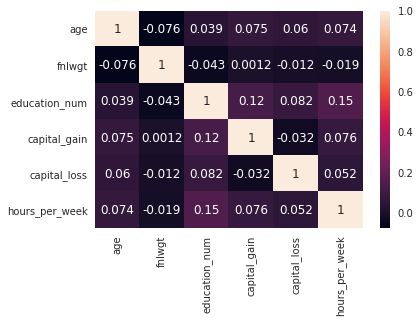

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

sns.heatmap(df2.corr(),annot=True)
plt.show()

In [22]:
df2.corr()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
age,1.000000,-0.076307,0.039157,0.074735,0.059868,0.073719
fnlwgt,-0.076307,1.000000,-0.042727,0.001243,-0.012283,-0.019191
education_num,0.039157,-0.042727,1.000000,0.122595,0.081555,0.149953
capital_gain,0.074735,0.001243,0.122595,1.000000,-0.031514,0.076138
capital_loss,0.059868,-0.012283,0.081555,-0.031514,1.000000,0.052249
hours_per_week,0.073719,-0.019191,0.149953,0.076138,0.052249,1.000000


In [23]:
# 3. Data Preprocessing

In [24]:
data.dtypes

[('age', 'string'),
 ('workclass', 'string'),
 ('fnlwgt', 'string'),
 ('education', 'string'),
 ('education_num', 'string'),
 ('marital_status', 'string'),
 ('occupation', 'string'),
 ('relationship', 'string'),
 ('race', 'string'),
 ('sex', 'string'),
 ('capital_gain', 'string'),
 ('capital_loss', 'string'),
 ('hours_per_week', 'string'),
 ('native_country', 'string'),
 ('income', 'string')]

In [25]:
# 1) Category Indexing

StringIndexer_workclass=StringIndexer(inputCol='workclass',outputCol='workclass_Ind')
StringIndexer_education=StringIndexer(inputCol='education',outputCol='education_Ind')

StringIndexer_marital_statusl=StringIndexer(inputCol='marital_status',outputCol='marital_status_Ind')
StringIndexer_occupation=StringIndexer(inputCol='occupation',outputCol='occupation_Ind')
StringIndexer_relationship=StringIndexer(inputCol='relationship',outputCol='relationship_Ind')
StringIndexer_race=StringIndexer(inputCol='race',outputCol='race_Ind')
StringIndexer_sex=StringIndexer(inputCol='sex',outputCol='sex_Ind')
StringIndexer_native_country=StringIndexer(inputCol='native_country',outputCol='native_country_Ind')

# Label Indexing for income column as income_class 
StringIndexer_income=StringIndexer(inputCol='income',outputCol='income_class')

In [26]:
# 2) One-Hot Encoding

OneHotEncoder_workclass=OneHotEncoder(inputCol='workclass_Ind',outputCol='workclass_feat')
OneHotEncoder_education=OneHotEncoder(inputCol='education_Ind',outputCol='education_feat')
OneHotEncoder_marital_status=OneHotEncoder(inputCol='marital_status_Ind',outputCol='marital_status_feat')
OneHotEncoder_occupation=OneHotEncoder(inputCol='occupation_Ind',outputCol='occupation_feat')
OneHotEncoder_relationship=OneHotEncoder(inputCol='relationship_Ind',outputCol='relationship_feat')
OneHotEncoder_race=OneHotEncoder(inputCol='race_Ind',outputCol='race_feat')
OneHotEncoder_sex=OneHotEncoder(inputCol='sex_Ind',outputCol='sex_feat')
OneHotEncoder_native_country=OneHotEncoder(inputCol='native_country_Ind',outputCol='native_country_feat')

In [27]:
# vector assembler
assemble_cols=['workclass_feat','education_feat','marital_status_feat','occupation_feat','relationship_feat','race_feat','sex_feat',
               'native_country_feat']

# so we are combining all the above columns into a single vector
assemble_features=VectorAssembler(inputCols=assemble_cols,outputCol='features')

In [28]:
# Make it as an array of stages so that it can be passed to a pipeline

basePipeline=[StringIndexer_workclass,StringIndexer_education,StringIndexer_marital_statusl,StringIndexer_occupation,StringIndexer_relationship,StringIndexer_race,
              StringIndexer_sex,StringIndexer_native_country,StringIndexer_income,OneHotEncoder_workclass,OneHotEncoder_education,
              OneHotEncoder_marital_status,OneHotEncoder_occupation,OneHotEncoder_relationship,OneHotEncoder_race,OneHotEncoder_sex,
              OneHotEncoder_native_country,assemble_features]

In [29]:
# 4. Build the Pipeline to perform multiple tasks

pipeline=Pipeline(stages=basePipeline)
df2_model=pipeline.fit(data)
df2=df2_model.transform(data)
df2

DataFrame[age: string, workclass: string, fnlwgt: string, education: string, education_num: string, marital_status: string, occupation: string, relationship: string, race: string, sex: string, capital_gain: string, capital_loss: string, hours_per_week: string, native_country: string, income: string, workclass_Ind: double, education_Ind: double, marital_status_Ind: double, occupation_Ind: double, relationship_Ind: double, race_Ind: double, sex_Ind: double, native_country_Ind: double, income_class: double, workclass_feat: vector, education_feat: vector, marital_status_feat: vector, occupation_feat: vector, relationship_feat: vector, race_feat: vector, sex_feat: vector, native_country_feat: vector, features: vector]

In [30]:
log_reg = LogisticRegression(labelCol='income_class',maxIter=5) # creating logistic regression
pl_log_reg = basePipeline + [log_reg] # add logistic regression to the base pipeline

pipeline_lr=Pipeline(stages=pl_log_reg)

# displaying to check

df_lr = pipeline_lr.fit(data).transform(data)
df_lr.toPandas().head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,...,marital_status_feat,occupation_feat,relationship_feat,race_feat,sex_feat,native_country_feat,features,rawPrediction,probability,prediction
0,22,Private,148187,11th,7,Never-married,Other-service,Other-relative,White,Male,...,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)",(1.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.4827568068981547, -3.4827568068981547]","[0.9701931460780852, 0.02980685392191496]",0.0
1,77,Self-emp-not-inc,138714,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)",(1.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.22651987093516024, -0.22651987093516024]","[0.5563890575866912, 0.44361094241330884]",0.0
2,47,?,224108,HS-grad,9,Widowed,?,Unmarried,White,Female,...,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0)","(1.0, 0.0, 0.0, 0.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[3.560057701080325, -3.560057701080325]","[0.9723491290880305, 0.027650870911969428]",0.0
3,23,Private,314894,HS-grad,9,Never-married,Exec-managerial,Own-child,White,Female,...,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[2.8635327721468653, -2.8635327721468653]","[0.9460140080561056, 0.05398599194389434]",0.0
4,46,Private,166181,Some-college,10,Never-married,Adm-clerical,Own-child,Black,Female,...,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.854021348332892, -3.854021348332892]","[0.9792455419031698, 0.020754458096830238]",0.0


In [31]:
DT_reg = DecisionTreeClassifier(labelCol='income_class') 
pl_DT_reg = basePipeline + [DT_reg] 

pipeline_DT=Pipeline(stages=pl_DT_reg)

In [32]:
RF_reg = RandomForestClassifier(labelCol='income_class') 
pl_RF_reg = basePipeline + [RF_reg] 

pipeline_RF=Pipeline(stages=pl_RF_reg)

In [33]:
nb_reg = NaiveBayes(labelCol='income_class') 
pl_nb_reg = basePipeline + [nb_reg]

pipeline_nb=Pipeline(stages=pl_nb_reg)


In [34]:
GBT_reg = GBTClassifier(labelCol='income_class',maxIter=5) 
pl_GBT_reg = basePipeline + [GBT_reg] 

pipeline_GBT=Pipeline(stages=pl_GBT_reg)

In [35]:
# 5. Split the dataset into two parts (80%-20%) as Train and Test Datasets
training_data, testing_data = data.randomSplit([0.8, 0.2], 3) # 80-20 split

print("Number of training records: " + str(training_data.count()))
print("Number of testing records : " + str(testing_data.count()))

Number of training records: 74125
Number of testing records : 18436


In [36]:
lr_model=pipeline_lr.fit(training_data)
pred_log_reg=lr_model.transform(testing_data) 
pred_log_reg

DataFrame[age: string, workclass: string, fnlwgt: string, education: string, education_num: string, marital_status: string, occupation: string, relationship: string, race: string, sex: string, capital_gain: string, capital_loss: string, hours_per_week: string, native_country: string, income: string, workclass_Ind: double, education_Ind: double, marital_status_Ind: double, occupation_Ind: double, relationship_Ind: double, race_Ind: double, sex_Ind: double, native_country_Ind: double, income_class: double, workclass_feat: vector, education_feat: vector, marital_status_feat: vector, occupation_feat: vector, relationship_feat: vector, race_feat: vector, sex_feat: vector, native_country_feat: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [37]:
dt_model=pipeline_DT.fit(training_data)
pred_dt_model=dt_model.transform(testing_data) 
pred_dt_model

DataFrame[age: string, workclass: string, fnlwgt: string, education: string, education_num: string, marital_status: string, occupation: string, relationship: string, race: string, sex: string, capital_gain: string, capital_loss: string, hours_per_week: string, native_country: string, income: string, workclass_Ind: double, education_Ind: double, marital_status_Ind: double, occupation_Ind: double, relationship_Ind: double, race_Ind: double, sex_Ind: double, native_country_Ind: double, income_class: double, workclass_feat: vector, education_feat: vector, marital_status_feat: vector, occupation_feat: vector, relationship_feat: vector, race_feat: vector, sex_feat: vector, native_country_feat: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [38]:
rf_model=pipeline_RF.fit(training_data)
pred_rf_model=rf_model.transform(testing_data) 
pred_rf_model

DataFrame[age: string, workclass: string, fnlwgt: string, education: string, education_num: string, marital_status: string, occupation: string, relationship: string, race: string, sex: string, capital_gain: string, capital_loss: string, hours_per_week: string, native_country: string, income: string, workclass_Ind: double, education_Ind: double, marital_status_Ind: double, occupation_Ind: double, relationship_Ind: double, race_Ind: double, sex_Ind: double, native_country_Ind: double, income_class: double, workclass_feat: vector, education_feat: vector, marital_status_feat: vector, occupation_feat: vector, relationship_feat: vector, race_feat: vector, sex_feat: vector, native_country_feat: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [39]:
nb_model=pipeline_nb.fit(training_data)
pred_nb_model=nb_model.transform(testing_data) 
pred_nb_model

DataFrame[age: string, workclass: string, fnlwgt: string, education: string, education_num: string, marital_status: string, occupation: string, relationship: string, race: string, sex: string, capital_gain: string, capital_loss: string, hours_per_week: string, native_country: string, income: string, workclass_Ind: double, education_Ind: double, marital_status_Ind: double, occupation_Ind: double, relationship_Ind: double, race_Ind: double, sex_Ind: double, native_country_Ind: double, income_class: double, workclass_feat: vector, education_feat: vector, marital_status_feat: vector, occupation_feat: vector, relationship_feat: vector, race_feat: vector, sex_feat: vector, native_country_feat: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [40]:
gbt_model=pipeline_GBT.fit(training_data)
pred_gbt_model=gbt_model.transform(testing_data) 
pred_gbt_model

DataFrame[age: string, workclass: string, fnlwgt: string, education: string, education_num: string, marital_status: string, occupation: string, relationship: string, race: string, sex: string, capital_gain: string, capital_loss: string, hours_per_week: string, native_country: string, income: string, workclass_Ind: double, education_Ind: double, marital_status_Ind: double, occupation_Ind: double, relationship_Ind: double, race_Ind: double, sex_Ind: double, native_country_Ind: double, income_class: double, workclass_feat: vector, education_feat: vector, marital_status_feat: vector, occupation_feat: vector, relationship_feat: vector, race_feat: vector, sex_feat: vector, native_country_feat: vector, features: vector, prediction: double]

In [42]:
evaluator = BinaryClassificationEvaluator(labelCol='income_class',metricName="areaUnderROC")

print('Test Area Under ROC for logistic regression ', evaluator.evaluate(pred_log_reg))

print('Test Area Under ROC for Decision Tree ', evaluator.evaluate(pred_dt_model))

print('Test Area Under ROC for random forest ', evaluator.evaluate(pred_rf_model))

print('Test Area Under ROC for  Naive Bayes', evaluator.evaluate(pred_nb_model))

print('Test Area Under ROC for GBT ', evaluator.evaluate(pred_gbt_model))



('Test Area Under ROC for logistic regression ', 0.8742523925475205)
('Test Area Under ROC for Decision Tree ', 0.5144960147860625)
('Test Area Under ROC for random forest ', 0.8616063451290223)
('Test Area Under ROC for  Naive Bayes', 0.7597804584441785)


In [43]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator2 = MulticlassClassificationEvaluator(labelCol='income_class',metricName="accuracy")

print('accuracy for logistic regression ', evaluator2.evaluate(pred_log_reg))

print('accuracy for Decision Tree ', evaluator2.evaluate(pred_dt_model))

print('accuracy for random forest ', evaluator2.evaluate(pred_rf_model))

print('accuracy for  Naive Bayes', evaluator2.evaluate(pred_nb_model))

print('accuracy for GBT ', evaluator2.evaluate(pred_gbt_model))


('accuracy for logistic regression ', 0.8320134519418529)
('accuracy for Decision Tree ', 0.8284877413755696)
('accuracy for random forest ', 0.817151225862443)
('accuracy for  Naive Bayes', 0.7945324365372098)
('accuracy for GBT ', 0.8294098502929051)


In [44]:
models=['logistic regression','Decision Tree','random forest','Naive Bayes','GBT']
accuracy=[evaluator2.evaluate(pred_log_reg),evaluator2.evaluate(pred_dt_model),evaluator2.evaluate(pred_rf_model),evaluator2.evaluate(pred_nb_model),evaluator2.evaluate(pred_gbt_model)]

In [45]:
max_acc=max(accuracy)
max_acc

0.8320134519418529

In [46]:
for i in range(0,len(accuracy)):
    if(accuracy[i]==max_acc):
        print(" The Best Model is "+models[i])

 The Best Model is logistic regression


In [48]:
# Hyper Parameter tuning for logistic reggression

param_log_reg = ParamGridBuilder().baseOn({pipeline.stages: pl_log_reg}).addGrid(log_reg.regParam,[0.02, .08])\
                .addGrid(log_reg.elasticNetParam,[0.2, 0.6]).build()
evaluator_lr = MulticlassClassificationEvaluator(labelCol='income_class',metricName="accuracy")    

lrcv = CrossValidator(estimator = pipeline_lr,
                    estimatorParamMaps = param_log_reg,
                    evaluator = evaluator_lr,
                    numFolds = 2)

lrcvModel = lrcv.fit(training_data)
print(lrcvModel)


CrossValidatorModel_48bd81d0a3a3c407b31f


In [53]:
prediction = lrcvModel.transform(testing_data)

In [54]:
prediction.toPandas().head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,...,marital_status_feat,occupation_feat,relationship_feat,race_feat,sex_feat,native_country_feat,features,rawPrediction,probability,prediction
0,17,?,110998,Some-college,10,Never-married,?,Own-child,Asian-Pac-Islander,Female,...,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0)",(0.0),"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.462995436380335, -3.462995436380335]","[0.969616338020382, 0.03038366197961793]",0.0
1,17,?,114798,11th,7,Never-married,?,Own-child,White,Female,...,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.878927203762599, -3.878927203762599]","[0.9797457252467254, 0.020254274753274668]",0.0
2,17,?,145258,11th,7,Never-married,?,Other-relative,White,Female,...,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.228299780445534, -3.228299780445534]","[0.9618854687235217, 0.038114531276478326]",0.0
3,17,?,158762,10th,6,Never-married,?,Own-child,White,Female,...,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.877480761592218, -3.877480761592218]","[0.9797170020650194, 0.02028299793498057]",0.0
4,17,?,158762,10th,6,Never-married,?,Own-child,White,Female,...,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.877480761592218, -3.877480761592218]","[0.9797170020650194, 0.02028299793498057]",0.0


In [55]:
print(evaluator_lr.evaluate(prediction))

0.826372315036


In [58]:
param_random_forest = ParamGridBuilder().baseOn({pipeline.stages: pipeline_RF})\
                    .addGrid(RF_reg.numTrees,[20,50,100]).build()

evaluator_RF = MulticlassClassificationEvaluator(labelCol='income_class',metricName="accuracy")    

rfcv = CrossValidator(estimator = pipeline_RF,
                    estimatorParamMaps = param_random_forest,
                    evaluator = evaluator_RF,
                    numFolds = 2)

rfcvModel = rfcv.fit(training_data)
print(rfcvModel)

prediction_rf = rfcvModel.transform(testing_data)

prediction_rf.toPandas().head()

print(evaluator_RF.evaluate(prediction_rf))

CrossValidatorModel_49818febc1812aae9e96
0.813028856585


In [57]:
param_naive_bayes = ParamGridBuilder().baseOn({pipeline.stages: pipeline_nb}).addGrid(nb_reg.smoothing,[0.4,1.0]).build()

evaluator_nb = MulticlassClassificationEvaluator(labelCol='income_class',metricName="accuracy")    

nbcv = CrossValidator(estimator = pipeline_nb,
                    estimatorParamMaps = param_naive_bayes,
                    evaluator = evaluator_nb,
                    numFolds = 2)

nbcvModel = nbcv.fit(training_data)
print(rfcvModel)

prediction_nb = nbcvModel.transform(testing_data)

prediction_nb.toPandas().head()

print(evaluator_nb.evaluate(prediction_nb))

CrossValidatorModel_46a8a51e03b6cab06b8d
0.794640919939


In [61]:
param_DT = ParamGridBuilder().baseOn({pipeline.stages: pipeline_nb}).addGrid(nb_reg.smoothing,[0.8,2.0]).build()
evaluator_dt = MulticlassClassificationEvaluator(labelCol='income_class',metricName="accuracy")     

dtcv = CrossValidator(estimator = pipeline_nb,
                    estimatorParamMaps = param_naive_bayes,
                    evaluator = evaluator_nb,
                    numFolds = 2)

dtcvModel = dtcv.fit(training_data)
print(dtcvModel)

prediction_dt = dtcvModel.transform(testing_data)

prediction_dt.toPandas().head()

print(evaluator_dt.evaluate(prediction_dt))

CrossValidatorModel_44b39ea6b5902ffa7ff4
0.794640919939


In [62]:
param_GBT = ParamGridBuilder().baseOn({pipeline.stages: pipeline_nb}).addGrid(nb_reg.smoothing,[0.8,2.0]).build()
evaluator_GBT = MulticlassClassificationEvaluator(labelCol='income_class',metricName="accuracy")     

gbtcv = CrossValidator(estimator = pipeline_nb,
                    estimatorParamMaps = param_naive_bayes,
                    evaluator = evaluator_nb,
                    numFolds = 2)

gbtcvModel = gbtcv.fit(training_data)
print(gbtcvModel)

prediction_gbt = gbtcvModel.transform(testing_data)

prediction_gbt.toPandas().head()

print(evaluator_GBT.evaluate(prediction_gbt))

CrossValidatorModel_4044960e30abd6f13e9c
0.794640919939


In [63]:
accuracy_tuned=[evaluator_lr.evaluate(prediction),evaluator_RF.evaluate(prediction_rf),evaluator_nb.evaluate(prediction_nb),evaluator_dt.evaluate(prediction_dt),evaluator_GBT.evaluate(prediction_gbt)]
accuracy_tuned

[0.8263723150357996,
 0.8130288565849425,
 0.7946409199392493,
 0.7946409199392493,
 0.7946409199392493]

In [64]:
df_comparison=pd.DataFrame()
df_comparison['Model']=models
df_comparison['accuracy']=accuracy
df_comparison['accuracy_tuned']=accuracy_tuned


df_comparison

,Model,accuracy,accuracy_tuned
0,logistic regression,0.832013,0.826372
1,Decision Tree,0.828488,0.813029
2,random forest,0.817151,0.794641
3,Naive Bayes,0.794532,0.794641
4,GBT,0.829410,0.794641
